In [1]:
#Full Res Version
myPath = "/data3/drsteph/SpatialMap01/oligodT/" # folder containing 
downsample_factor = 20 # just to speed up vignette estimation (reduces X and Y resolutions)
downslice_factor = 40 # just to speed up vignette estimation (use only a random subset of slices)

In [2]:
import h5py
import numpy as np
import matplotlib.pyplot as plt  
import os
from math import ceil, floor
import tifffile as tif
import json
from tqdm import tqdm 
from scipy.ndimage import gaussian_filter
from skimage.transform import resize, rescale

def str_arr_to_float(str_array):
    str_convert = ""
    for i in range(len(str_array)):
        str_convert += str_array[i].decode('UTF-8')
    float_conv = float(str_convert)
    return float_conv

def col_mult(a,b):
    a = np.array(a)
    b = np.array(b)
    tmp_array = np.zeros(a.shape)
    for i in range(len(b)):
        tmp_array[:,i] = a[:,i]*b[i]
    return tmp_array

def row_mult(a,b):
    a = np.array(a)
    b = np.array(b)
    tmp_array = np.zeros(a.shape)
    for i in range(len(b)):
        tmp_array[i,:] = a[i,:]*b[i]
    return tmp_array

def col_sum(a,b):
    a = np.array(a)
    b = np.array(b)
    b = np.transpose(b)
    tmp_array = np.zeros(a.shape)
    for i in range(len(b)):
        tmp_array[:,i] = a[:,i]+b[i]
    return tmp_array

def row_sum(a,b):
    a = np.array(a)
    b = np.array(b)
    tmp_array = np.zeros(a.shape)
    for i in range(len(b)):
        tmp_array[i,:] = a[i,:]+b[i]
    return tmp_array

def quantile(x,q,dim = -1):
    if dim == 0:
        row, col = x.shape
        quant = np.zeros([row,1])
        for i in range(row):
            y = np.sort(x[i,:])
            quant[i,0] = np.interp(q, np.linspace(1/(2*col), (2*col-1)/(2*col), col), y)
    elif dim == 1:
        row, col = x.shape
        quant = np.zeros([1,col])
        for i in range(col):
            y = np.sort(x[:,i])
            quant[0,i] = np.interp(q, np.linspace(1/(2*row), (2*row-1)/(2*row), row), y)
    elif dim == -1:
        x = x.reshape([len(x),])
        n = len(x)
        y = np.sort(x)
        quant = (np.interp(q, np.linspace(1/(2*n), (2*n-1)/(2*n), n), y))
    return quant

def spaced_quantiles(x,bins):
    vals = range(1,bins+1)
    percentiles = np.divide(vals,bins+1)
    bin_vals = np.array([quantile(x,q) for q in percentiles])
    return bin_vals

def isSquare(m): 
    return all (len (row) == len (m) for row in m)

def histc(X, bins):
    map_to_bins = np.digitize(X,bins)
    r = np.zeros(bins.shape)
    for i in map_to_bins:
        r[i-1] += 1
    return r

def linhistmatch(a,b,nbins):
    a_nan_idx = np.isnan(a)
    b_nan_idx = np.isnan(b)
    a = a[a_nan_idx==False]
    b = b[b_nan_idx==False]
    abins = np.transpose(spaced_quantiles(a,nbins))
    bbins = np.transpose(spaced_quantiles(b,nbins))
    ahat = np.transpose(histc(a,abins))
    bhat = np.transpose(histc(b,bbins))
    ones = np.ones(np.array([abins.shape[0],]))
    adj_abins = np.transpose(np.stack([abins, ones]))
    coeff = np.matmul(np.diag(bhat),adj_abins)
    ords = np.matmul(np.diag(bhat),bbins)
    if isSquare(coeff):
        beta = np.linalg.solve(coeff,ords)
    else:
        q,r = np.linalg.qr(coeff)
        beta = np.linalg.solve(r,np.matmul(np.linalg.pinv(q),ords))
    atransform = np.full(a_nan_idx.shape, np.nan)
    atransform[a_nan_idx==False] = a*beta[0] + beta[1]
    return atransform, beta

def vignette_correction(dataVolume, numbins = 200, templatetype = 'middle_slice',visual = 0):
    if visual == 1:
        dataVolume0=dataVolume;
    Sh = []
    Dh = []
    Sv = []
    Dv = []
    Xh = np.reshape(dataVolume,(dataVolume.shape[0],-1),order='F')
    Xht = np.zeros(Xh.shape)
    Bh = np.zeros([Xh.shape[0],2])
    if templatetype.lower() == 'middle_slice':
        template = Xh[int(np.round(dataVolume.shape[0]/2)),:]
        template = np.reshape(template, [1, len(template)],order='F')
    if templatetype.lower() == 'middle_20_slice':
        middle = int(np.round(dataVolume.shape[0]/2))
        middle_20 = range(middle-10,middle+11)
        template = Xh[middle_20,:]
        template = np.reshape(template,[1, -1],order='F')
    if templatetype.lower() == 'random':
        numel = Xh.size
        r = np.random.permutation(numel)
        Xh_flattened = np.reshape(Xh,[-1,1],order='F')
        template = Xh_flattened[r[0:Xh.shape[1]]]
        template = np.reshape(template,[1, -1],order='F')

    for i in range(Xh.shape[0]):
        Xht[i,:], Bh[i,:] = linhistmatch(Xh[i,:],template,numbins)

    Sh.append(Bh[:,0])
    Dh.append(Bh[:,1])
    new_dataVolume = np.reshape(Xht, dataVolume.shape,order='F')
    new_dataVolume = np.flip(new_dataVolume, 2)

    Xv = np.transpose(np.reshape(np.transpose(new_dataVolume,(1,0,2)),(new_dataVolume.shape[1],-1),order='F'))

    Xvt = np.zeros(Xv.shape)
    Bv = np.zeros([2,Xv.shape[1]])
    if templatetype.lower() == 'middle_slice':
        template = Xv[:,int(np.round(new_dataVolume.shape[0]/2))]
        template = np.reshape(template, [1, len(template)],order='F')

    if templatetype.lower() == 'middle_20_slice':
        middle = int(np.round(new_dataVolume.shape[0]/2))
        middle_20 = range(middle-10,middle+11)
        template = Xv[:,middle_20]
        template = np.reshape(template,[1, -1],order='F')

    if templatetype.lower() == 'random':
        numel = Xv.size
        r = np.random.permutation(numel)
        Xv_flattened = np.reshape(Xv,[-1,1],order='F')
        template = Xv_flattened[r[0:Xv.shape[0]]]
        template = np.reshape(template,[1, -1],order='F')

    for i in range(Xv.shape[1]):
        Xvt[:,i], Bv[:,i] = linhistmatch(Xv[:,i],template,numbins)
    Sv.append(Bv[0,:])
    Dv.append(Bv[1,:])

    final_dataVolume = np.reshape(np.transpose(Xvt),dataVolume.shape,order='F')
    s = dataVolume.shape[0]/5
    vfield_corrected = np.transpose(gaussian_filter(np.max(final_dataVolume, axis = 2), sigma=s,mode = 'nearest',truncate=2.0))
    vfield = np.transpose(gaussian_filter(np.max(dataVolume,axis =2), sigma=s,mode = 'nearest',truncate=2.0))
    Sh = np.array(Sh)
    Sv = np.array(Sv)
    Dh = np.array(Dh)
    Dv = np.array(Dv)
    return final_dataVolume, vfield, vfield_corrected, Sh, Sv, Dh, Dv
            
num_files = len([f for f in os.listdir(myPath)
     if f.endswith('.ims') and os.path.isfile(os.path.join(myPath, f))])

z_depths = []
t = 0
for i, file in tqdm(enumerate(os.listdir(myPath)),desc = "Loading..."):
    if file.endswith(".ims"):
        filename = os.path.join(myPath,file)
        h5 = h5py.File(filename,'r')
        dsi_im = h5["DataSetInfo"]["Image"]
        z_str = dsi_im.attrs['Z']
        z_float = str_arr_to_float(z_str)
        z_int = int(z_float)
        z_depths.append(z_float)
        x_str = dsi_im.attrs['X']
        x_float = str_arr_to_float(x_str)
        x_int = int(x_float)
        y_str = dsi_im.attrs['Y']
        y_float = str_arr_to_float(y_str)
        y_int = int(y_float)        
        if i == 0:
            channels = list(h5["DataSet"]["ResolutionLevel 0"]["TimePoint 0"].keys())
            r = np.random.permutation(z_int) - 1
            slicesamples=r[0:ceil(len(r)/downslice_factor)]
            if slicesamples.size == 0:
                slicesamples = [0]
            dataVolume=np.zeros([int(np.round(x_int/downsample_factor)),int(np.round(y_int/downsample_factor)),num_files*len(slicesamples),len(channels)])
        for k, s in enumerate(slicesamples):
            for chan, key in enumerate(channels):
                ds = h5["DataSet"]["ResolutionLevel 0"]["TimePoint 0"][key]["Data"][s,:,:]
                ds = np.array(ds)
                ds = np.transpose(ds)
                dataVolume[:,:,k,chan] = resize(ds,(int(np.round(x_int/downsample_factor)),int(np.round(y_int/downsample_factor))), preserve_range=True)
num_chans = len(channels)
vfield = {}
vfield_corrected = {}
Sh = {}
Sv = {}
Dh = {}
Dv = {}
for i in tqdm(range(num_chans),desc = "deriving vignette correction per channel..."): 
    _, vfield[channels[i]],vfield_corrected[channels[i]],Sh[channels[i]], Sv[channels[i]], Dh[channels[i]], Dv[channels[i]] = vignette_correction(dataVolume[:,:,:,i])

Loading...: 48it [18:07, 22.66s/it]
deriving vignette correction per channel...: 100%|██████████| 3/3 [05:31<00:00, 110.48s/it]


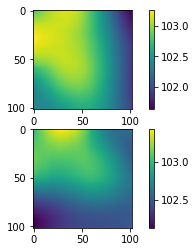

In [3]:
f, (ax1,ax2) = plt.subplots(2, 1, sharey=True)

c = ax1.imshow(vfield[channels[0]])
plt.colorbar(c, ax =ax1)
d = ax2.imshow(vfield_corrected[channels[0]])
plt.colorbar(d, ax =ax2)

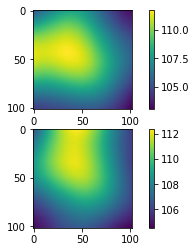

In [4]:
f, (ax1,ax2) = plt.subplots(2, 1, sharey=True)

c = ax1.imshow(vfield[channels[1]])
plt.colorbar(c, ax =ax1)
d = ax2.imshow(vfield_corrected[channels[1]])
plt.colorbar(d, ax =ax2)


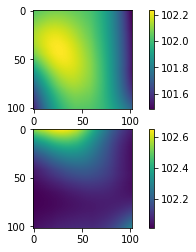

In [5]:
f, (ax1,ax2) = plt.subplots(2, 1, sharey=True)

c = ax1.imshow(vfield[channels[2]])
plt.colorbar(c, ax =ax1)
d = ax2.imshow(vfield_corrected[channels[2]])
plt.colorbar(d, ax =ax2)


(array([19.,  0.,  0.,  1.,  2.,  1.,  3.,  0.,  2.,  0.,  6.,  0.,  6.,
         0.,  1.,  0.,  3.,  4.,  0., 54.]),
 array([0.99854072, 0.99861369, 0.99868665, 0.99875961, 0.99883258,
        0.99890554, 0.99897851, 0.99905147, 0.99912443, 0.9991974 ,
        0.99927036, 0.99934332, 0.99941629, 0.99948925, 0.99956222,
        0.99963518, 0.99970814, 0.99978111, 0.99985407, 0.99992704,
        1.        ]),
 <BarContainer object of 20 artists>)

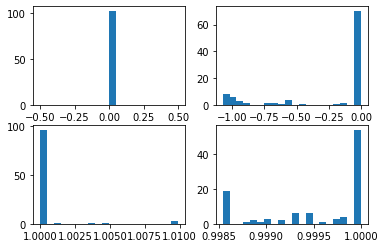

In [6]:
f, axs = plt.subplots(2, 2)
axs[0,0].hist(Dh[channels[0]][0,:],bins=20)
axs[0,1].hist(Dv[channels[0]][0,:],bins=20)
axs[1,0].hist(Sh[channels[0]][0,:],bins=20)
axs[1,1].hist(Sv[channels[0]][0,:],bins=20)

(array([ 1.,  0.,  1.,  5.,  2.,  4.,  5.,  7.,  6., 12., 13.,  1.,  7.,
         7., 12.,  4.,  2.,  2.,  1., 10.]),
 array([0.99586293, 0.99641746, 0.996972  , 0.99752653, 0.99808106,
        0.9986356 , 0.99919013, 0.99974466, 1.00029919, 1.00085373,
        1.00140826, 1.00196279, 1.00251733, 1.00307186, 1.00362639,
        1.00418093, 1.00473546, 1.00528999, 1.00584453, 1.00639906,
        1.00695359]),
 <BarContainer object of 20 artists>)

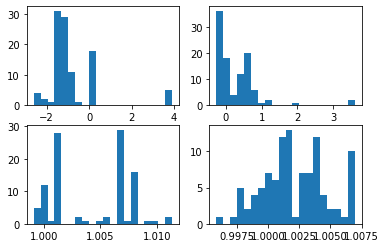

In [7]:
f, axs = plt.subplots(2, 2)
axs[0,0].hist(Dh[channels[1]][0,:],bins=20)
axs[0,1].hist(Dv[channels[1]][0,:],bins=20)
axs[1,0].hist(Sh[channels[1]][0,:],bins=20)
axs[1,1].hist(Sv[channels[1]][0,:],bins=20)

(array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 102.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]),
 array([0.5 , 0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ,
        1.05, 1.1 , 1.15, 1.2 , 1.25, 1.3 , 1.35, 1.4 , 1.45, 1.5 ]),
 <BarContainer object of 20 artists>)

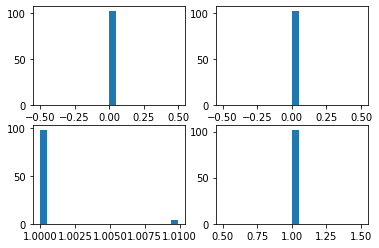

In [8]:
f, axs = plt.subplots(2, 2)
axs[0,0].hist(Dh[channels[2]][0,:],bins=20)
axs[0,1].hist(Dv[channels[2]][0,:],bins=20)
axs[1,0].hist(Sh[channels[2]][0,:],bins=20)
axs[1,1].hist(Sv[channels[2]][0,:],bins=20)

In [9]:
nSh = {}
nSv = {}
nDh = {}
nDv = {}
for i in range(num_chans):
    nSh[channels[i]] = rescale(Sh[channels[i]], x_int/len(Sh[channels[i]][0]))    
    nSv[channels[i]] = rescale(Sv[channels[i]], y_int/len(Sv[channels[i]][0]))
    nDh[channels[i]] = rescale(Dh[channels[i]], x_int/len(Dh[channels[i]][0]))
    nDv[channels[i]] = rescale(Dv[channels[i]], y_int/len(Dv[channels[i]][0]))


(array([1886.,   20.,   19.,    5.,    6.,    6.,    5.,   10.,   24.,
           7.,    3.,    3.,    3.,    3.,    3.,    3.,    3.,    3.,
           3.,   33.]),
 array([1.        , 1.00049505, 1.0009901 , 1.00148515, 1.0019802 ,
        1.00247525, 1.0029703 , 1.00346535, 1.0039604 , 1.00445545,
        1.0049505 , 1.00544554, 1.00594059, 1.00643564, 1.00693069,
        1.00742574, 1.00792079, 1.00841584, 1.00891089, 1.00940594,
        1.00990099]),
 <BarContainer object of 20 artists>)

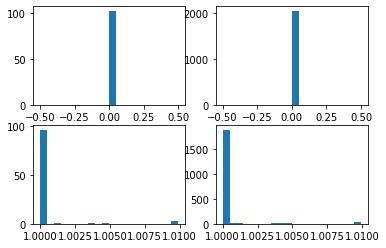

In [10]:
f, axs = plt.subplots(2, 2)
axs[0,0].hist(Dh[channels[0]][0,:],bins = 20)
axs[0,1].hist(nDh[channels[0]][0,:],bins = 20)
axs[1,0].hist(Sh[channels[0]][0,:],bins = 20)
axs[1,1].hist(nSh[channels[0]][0,:],bins = 20)

(array([110., 211.,  39., 486.,  41.,  42.,  43.,  23.,  13.,  14.,  22.,
         36., 535.,  43., 303.,  24.,  17.,  10.,   3.,  33.]),
 array([0.99911647, 0.99972856, 1.00034064, 1.00095273, 1.00156481,
        1.0021769 , 1.00278898, 1.00340107, 1.00401315, 1.00462524,
        1.00523732, 1.00584941, 1.00646149, 1.00707358, 1.00768566,
        1.00829775, 1.00890983, 1.00952192, 1.010134  , 1.01074609,
        1.01135817]),
 <BarContainer object of 20 artists>)

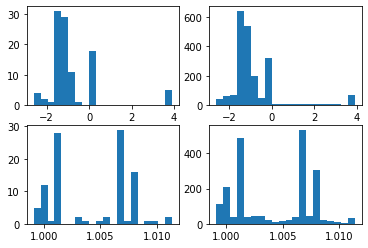

In [11]:
f, axs = plt.subplots(2, 2)
axs[0,0].hist(Dh[channels[1]][0,:],bins = 20)
axs[0,1].hist(nDh[channels[1]][0,:],bins = 20)
axs[1,0].hist(Sh[channels[1]][0,:],bins = 20)
axs[1,1].hist(nSh[channels[1]][0,:],bins = 20)

(array([1932.,    4.,    4.,    4.,    4.,    4.,    4.,    4.,    4.,
           4.,    5.,    5.,    5.,    5.,    5.,    5.,    5.,    5.,
           5.,   35.]),
 array([1.        , 1.00049505, 1.0009901 , 1.00148515, 1.0019802 ,
        1.00247525, 1.0029703 , 1.00346535, 1.0039604 , 1.00445545,
        1.0049505 , 1.00544554, 1.00594059, 1.00643564, 1.00693069,
        1.00742574, 1.00792079, 1.00841584, 1.00891089, 1.00940594,
        1.00990099]),
 <BarContainer object of 20 artists>)

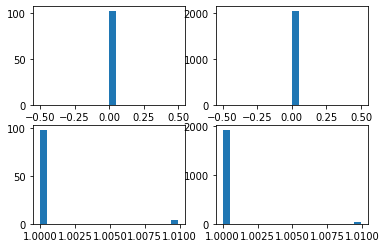

In [12]:
f, axs = plt.subplots(2, 2)
axs[0,0].hist(Dh[channels[2]][0,:],bins = 20)
axs[0,1].hist(nDh[channels[2]][0,:],bins = 20)
axs[1,0].hist(Sh[channels[2]][0,:],bins = 20)
axs[1,1].hist(nSh[channels[2]][0,:],bins = 20)

In [ ]:
dataSlice = {}
corr_dataSlice = {}
positions = []
files = []
meta_pos = {}
raw_stacks = []
corr_stacks = []
vfield_stacks = []
vfield_corr_stacks = []
    
for s in tqdm(range(5),desc = "Loading..."):
    counter = 0
    for k, file in enumerate(os.listdir(myPath)):
        if file.endswith(".ims"):    

            files.append(os.path.join(myPath, file))
            filename = os.path.join(myPath, file)

            h5 = h5py.File(filename, 'r')
            dsi_img = h5["DataSetInfo"]["Image"]

            emax0_str_arr = dsi_img.attrs['ExtMax0']
            extmax0 = str_arr_to_float(emax0_str_arr)
            emax1_str_arr = dsi_img.attrs['ExtMax1']
            extmax1 = str_arr_to_float(emax1_str_arr)

            emin0_str_arr = dsi_img.attrs['ExtMin0']
            extmin0 = str_arr_to_float(emin0_str_arr)

            emin1_str_arr = dsi_img.attrs['ExtMin1']
            extmin1 = str_arr_to_float(emin1_str_arr)

            positions.append([extmin0, extmax0, extmin1, extmax1])
            for chan in channels:
                ds = h5["DataSet"]["ResolutionLevel 0"]["TimePoint 0"][chan]["Data"][s,:,:]
                ds = np.array(ds)
                ds = np.transpose(ds)
                corr_ds = ds
                corr_ds = col_sum(col_mult(corr_ds,nSh[chan][0]),nDh[chan][0])
                corr_ds = row_sum(row_mult(corr_ds,nSv[chan][0]),nDv[chan][0])
                dataSlice[chan+str(counter)] = ds
                corr_dataSlice[chan+str(counter)] = corr_ds
            meta_pos[file] = [extmin0, extmax0, extmin1, extmax1]
            counter += 1
        
    positions = np.array(positions)
    min_x = min(positions[:,0])
    min_y = min(positions[:,2])
    positions[:,0] = positions[:,0] - min_x
    positions[:,1] = positions[:,1] - min_x
    positions[:,2] = positions[:,2] - min_y
    positions[:,3] = positions[:,3] - min_y
    adjustment = np.abs(positions[0,1] - positions[0,0])
    positions = np.multiply(np.divide(positions,adjustment),x_int)
    positions=np.round(positions)

    I=np.zeros((int(max(positions[:,1])),int(max(positions[:,3])),num_chans))
    Icorr = np.zeros(I.shape)
    vignette_field = np.zeros(I.shape)
    vignette_field_corrected = np.zeros(I.shape)
    counts = np.zeros(I.shape)

    for k in range(num_files):
        x_min = int(positions[k,0])
        x_max = int(positions[k,1])
        y_min = int(positions[k,2])
        y_max = int(positions[k,3])
        for i, chan in enumerate(channels):
            I[x_min:x_max,y_min:y_max,i] = I[x_min:x_max,y_min:y_max,i] + resize(dataSlice[chan+str(k)],(x_max-x_min, y_max-y_min),preserve_range=True)            
            Icorr[x_min:x_max,y_min:y_max,i] = Icorr[x_min:x_max,y_min:y_max,i] + resize(corr_dataSlice[chan+str(k)],(x_max-x_min, y_max-y_min),preserve_range=True)
            vignette_field[x_min:x_max,y_min:y_max,i] = vignette_field[x_min:x_max,y_min:y_max,i] + resize(vfield[chan], (x_max-x_min, y_max-y_min),preserve_range=True)
            vignette_field_corrected[x_min:x_max,y_min:y_max,i] = vignette_field_corrected[x_min:x_max,y_min:y_max,i] + resize(vfield_corrected[chan], (x_max-x_min, y_max-y_min),preserve_range=True)
            counts[x_min:x_max,y_min:y_max,i] = counts[x_min:x_max,y_min:y_max,i] + np.ones((x_max-x_min,y_max-y_min))
    I=np.divide(I, counts)
    Icorr=np.divide(Icorr,counts)
    vignette_field = np.divide(vignette_field,counts)
    vignette_field_corrected = np.divide(vignette_field_corrected,counts)

    if len(raw_stacks) == 0:
        raw_stacks = np.reshape(I, (I.shape[0],I.shape[1],I.shape[2],1),order = 'F')
        corr_stacks = np.reshape(Icorr, (I.shape[0],I.shape[1],I.shape[2],1),order = 'F')
        vfield_stacks = np.reshape(vignette_field, (I.shape[0],I.shape[1],I.shape[2],1),order = 'F')
        vfield_corr_stacks = np.reshape(vignette_field_corrected, (I.shape[0],I.shape[1],I.shape[2],1),order = 'F')        
    else:
        I_int = np.reshape(I, (I.shape[0],I.shape[1],I.shape[2],1),order = 'F')
        raw_stacks = np.concatenate([raw_stacks,I_int],axis = 3)

        Icorr_int = np.reshape(Icorr, (I.shape[0],I.shape[1],I.shape[2],1),order = 'F')
        corr_stacks = np.concatenate([corr_stacks,Icorr_int],axis = 3)

        vfield_int = np.reshape(vignette_field, (I.shape[0],I.shape[1],I.shape[2],1),order = 'F')
        vfield_stacks = np.concatenate([vfield_stacks,vfield_int],axis = 3)

        vfield_corr_int = np.reshape(vignette_field_corrected, (I.shape[0],I.shape[1],I.shape[2],1),order = 'F')
        vfield_corr_stacks = np.concatenate([vfield_corr_stacks,vfield_corr_int],axis = 3)

    positions = []
    dataSlice = {}   
    corr_dataSlice = {}

#raw_stacks = raw_stacks.astype('int32')
tif.imsave('3_chan_bIraw_full_0.tif', raw_stacks, bigtiff=True)

#corr_stacks = corr_stacks.astype('int32')
tif.imsave('3_chan_bIcorr_full_0.tif', corr_stacks, bigtiff=True)

# vfield_stacks = vfield_stacks.astype('int32')
tif.imsave('vfield.tif', vfield_stacks, bigtiff=True)

# vfield_corr_stacks = vfield_corr_stacks.astype('int32')
tif.imsave('vfield_corr.tif', vfield_corr_stacks, bigtiff=True)


Loading...:  40%|████      | 2/5 [25:42<32:31, 650.66s/it]

In [ ]:
f, axs = plt.subplots(2, 2, sharey=True)
axs[0,0].imshow(raw_stacks[:,:,0,0])
axs[0,1].imshow(corr_stacks[:,:,0,0])
axs[1,0].imshow(vfield_stacks[:,:,0,0])
axs[1,1].imshow(vfield_corr_stacks[:,:,0,0])

In [ ]:
f, axs = plt.subplots(2, 2, sharey=True)
axs[0,0].imshow(raw_stacks[:,:,1,0])
axs[0,1].imshow(corr_stacks[:,:,1,0])
axs[1,0].imshow(vfield_stacks[:,:,1,0])
axs[1,1].imshow(vfield_corr_stacks[:,:,1,0])

In [ ]:
f, axs = plt.subplots(2, 2, sharey=True)
axs[0,0].imshow(raw_stacks[:,:,2,0])
axs[0,1].imshow(corr_stacks[:,:,2,0])
axs[1,0].imshow(vfield_stacks[:,:,2,0])
axs[1,1].imshow(vfield_corr_stacks[:,:,2,0])